# 06 — Results Aggregation and Statistical Testing

This notebook will aggregate JSON reports, summary tables and statistical analyses of the models.

In [4]:
import pandas as pd, json, glob, os
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

files = glob.glob("../results/models/*.json", recursive=True)
records = []
for f in files:
    if "regression" not in f.lower():   
        continue
    with open(f) as j:
        d = json.load(j)
        d["model"] = Path(f).stem.replace("_test_report","") 
        records.append(d)
df = pd.DataFrame(records)
df.head()

,r2_score,adjusted_r2,mae,mse,rmse,pearson_r,model,best_params,cv_r2_mean,cv_r2_per_fold
0,0.796172,0.796172,0.042927,0.002745,0.052394,0.916207,DecisionTree_regression,NaN,NaN,NaN
1,0.805847,0.805847,0.040873,0.002615,0.051135,0.912658,kNN_regression,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,RandomForest_Regression_cv,"{'max_depth': 10, 'min_samples_leaf': 2, 'n_es...",0.748986,"[0.7698557403918665, 0.8075106693501438, 0.789..."
3,0.933420,0.933420,0.024747,0.000897,0.029945,0.976390,RandomForest_regression,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,SVM_Regression_cv,"{'svm__C': 0.1, 'svm__degree': 2, 'svm__gamma'...",0.579626,"[0.4856975399525615, 0.7419039979556681, 0.690..."


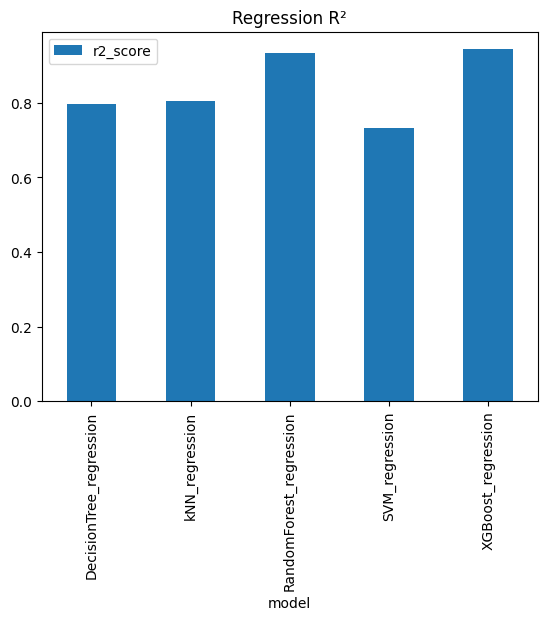

In [5]:
# Plot summary bars for regression R²
reg = df[df["model"].str.contains("regression")]
reg.plot.bar(x="model", y="r2_score", title="Regression R²")
output_path = os.path.join("../results/plots", "Regression_R^2_Table.png")
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()

RF per-fold: [0.7698557403918665, 0.8075106693501438, 0.7895764979536288, 0.6708366287678573, 0.7071514188816523]
SVM per-fold: [0.4856975399525615, 0.7419039979556681, 0.6907941288305635, 0.4316139453690687, 0.548121046684584]
Paired t-test (RF vs SVM): t=4.113, p=0.015


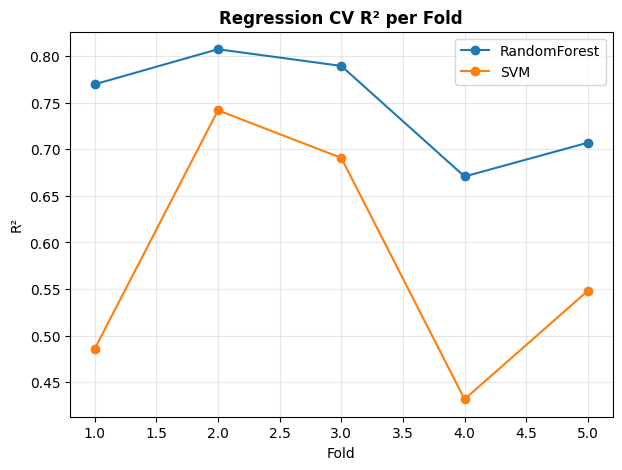

In [ ]:
# ---- Load CV JSONs for regression models ----
def load_cv_scores(model_name, metric_key="cv_r2_per_fold", base_dir="../results/models"):
    """Utility to load per-fold CV scores or fall back to single summary value."""
    path = Path(base_dir) / f"{model_name}_cv.json"
    if not path.exists():
        raise FileNotFoundError(f"No CV file found for {model_name} in {base_dir}")
    with open(path) as f:
        d = json.load(f)
    # Prefer per-fold scores if present, otherwise wrap single value
    return d.get(metric_key) or [d.get("cv_f1_macro") or d.get("cv_r2_mean")]

# compare regression CV R² between RandomForest and SVM
rf_cv = load_cv_scores("RandomForest_Regression", metric_key="cv_r2_per_fold")
svm_cv = load_cv_scores("SVM_Regression", metric_key="cv_r2_per_fold")

print("RF per-fold:", rf_cv)
print("SVM per-fold:", svm_cv)

# ---- Paired t-test ----
if len(rf_cv) == len(svm_cv) and len(rf_cv) > 1:
    t, p = ttest_rel(rf_cv, svm_cv)
    print(f"Paired t-test (RF vs SVM): t={t:.3f}, p={p:.3f}")
else:
    print("Not enough per-fold values for t-test (need ≥2 and equal length).")

# Save 
cv_df = pd.DataFrame({
    "Fold": range(1, len(rf_cv) + 1),
    "RandomForest": rf_cv,
    "SVM": svm_cv
}).melt(id_vars="Fold", var_name="Model", value_name="R²")

# ---- Plot per-fold comparison ----
plt.figure(figsize=(7, 5))
for model in cv_df["Model"].unique():
    subset = cv_df[cv_df["Model"] == model]
    plt.plot(subset["Fold"], subset["R²"], marker="o", label=model)

plt.title("Regression CV R² per Fold", fontsize=12, weight="bold")
plt.xlabel("Fold")
plt.ylabel("R²")
plt.legend()
plt.grid(alpha=0.3)

# ---- Save to file ----
output_path = Path("../results/plots") / "Regression_CV_R2_Comparison.png"
plt.savefig(output_path, bbox_inches="tight", dpi=300)
plt.show()
